In [1]:
!pip install torchgan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=23aa50ceb62589b9013e977096a72e3a1475bc0eebc97c2b53a8bd3aa7a99a50
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tarfile as tf
import torch
import torchvision
from torch.optim import Adam
from torchvision import transforms, datasets
import torchgan
from torchgan.models import DCGANGenerator, DCGANDiscriminator
from torchgan.losses import MinimaxGeneratorLoss, MinimaxDiscriminatorLoss
from torchgan.trainer import Trainer
from torchvision.utils import save_image

In [3]:
data_dir = '/kaggle/input/butterfly'
transform = transforms.Compose(
        [
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,)),
        ])# compose transforms here
                               
                               
dataset = datasets.ImageFolder(data_dir, transform=transform) #  create the ImageFolder
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True) # use the ImageFolder dataset to create the DataLoader

In [4]:
%%capture
trainer = Trainer({"generator": {"name": DCGANGenerator, "args": {"out_channels": 3, "step_channels": 16}, "optimizer": {"name": Adam, "args": {"lr": 0.0002, "betas": (0.5, 0.999)}}},
                   "discriminator": {"name": DCGANDiscriminator, "args": {"in_channels": 3, "step_channels": 16}, "optimizer": {"name": Adam, "args": {"lr": 0.0002, "betas": (0.5, 0.999)}}}},
                  [MinimaxGeneratorLoss(), MinimaxDiscriminatorLoss()],
                  sample_size=64, epochs=400)

trainer(loader)

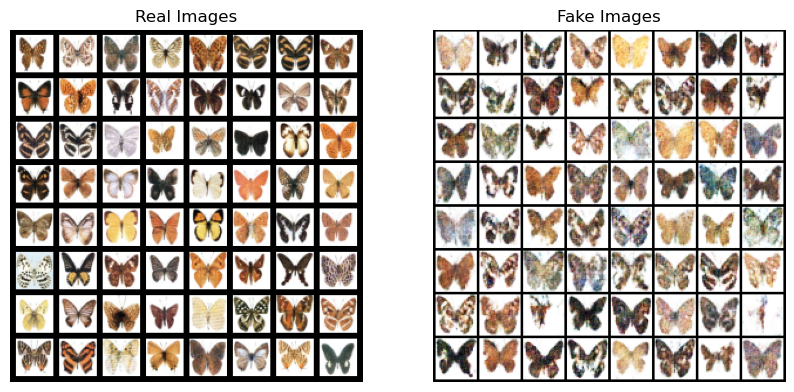

In [5]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(loader))

# Plot the real images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            real_batch[0].to(torch.device("cuda:0"))[:64], padding=5, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, trainer.epochs)))
plt.show()

In [6]:
os.mkdir('../images')
z = torch.randn(128, 100, device = torch.device("cuda"))
gen_images = trainer.generator(z)
images = gen_images.to("cpu").clone().detach()
images = images.numpy().transpose(0, 2, 3, 1)
for i in range(gen_images.size(0)):
    save_image(gen_images[i, :, :, :], os.path.join('../images', f'{i+1}.jpg'))

In [7]:
with tf.open('images.tgz', 'w:gz') as tar:
    tar.add('../images', arcname = os.path.basename('../images'))